# Experiment 2: Data Augmentation - Qualitative Mesh Comparison

In [1]:
import pandas as pd

In [2]:
results = pd.read_csv("../eval/TestEvaluation/mesh_eval_results.csv")

In [3]:
relevant_models = [
    "vh_2img",
    "pix2vox_base",
    "pix2vox_aug",
    "pollen_augmentation2",
    "pollen_256_2",
    "refine_p2mpp_2_inputs_none_augmentation",
    "refine_p2mpp_augmentation_2_inputs",
    # extend with Pixel2Mesh++ and PixelNeRF names as in the CSV file
]

filtered = results[results["model"].isin(relevant_models)]

aggregated = filtered.groupby("model", as_index=False).agg(
    mean_chamfer=("chamfer", "mean"),
    std_chamfer=("chamfer", "std"),
    mean_fscore_1=("fscore_1", "mean"),
    std_fscore_1=("fscore_1", "std"),
    mean_fscore_2_5=("fscore_2_5", "mean"),
    std_fscore_2_5=("fscore_2_5", "std"),
    mean_fscore_5=("fscore_5", "mean"),
    std_fscore_5=("fscore_5", "std"),
    mean_iou=("voxel_iou", "mean"),
    std_iou=("voxel_iou", "std"),
)

aggregated

model  mean_chamfer  std_chamfer  \
0                              pix2vox_aug      0.059839     0.020741   
1                             pix2vox_base      0.067947     0.022273   
2                             pollen_256_2      0.045997     0.018514   
3                     pollen_augmentation2      0.043322     0.013381   
4  refine_p2mpp_2_inputs_none_augmentation      0.059834     0.012748   
5       refine_p2mpp_augmentation_2_inputs      0.051909     0.022576   
6                                  vh_2img      0.091423     0.024904   

   mean_fscore_1  std_fscore_1  mean_fscore_2_5  std_fscore_2_5  \
0       0.166688      0.060798         0.603350        0.151200   
1       0.153941      0.056904         0.558601        0.132500   
2       0.258567      0.104156         0.751671        0.154180   
3       0.259836      0.088822         0.762052        0.122709   
4       0.152248      0.033312         0.580005        0.083970   
5       0.212900      0.090377         0.690881        0.155863   
6       0.109239      0.040237         0.416278        0.101777   

   mean_fscore_5  std_fscore_5  mean_iou   std_iou  
0       0.848221      0.121432  0.713982  0.176484  
1       0.805877      0.118578  0.610673  0.199088  
2       0.895576      0.105937  0.817668  0.083390  
3       0.909808      0.083156  0.827635  0.065013  
4       0.836107      0.079522  0.352147  0.092705  
5       0.884539      0.124626  0.406086  0.234189  
6       0.664201      0.120545  0.637425  0.090634

In [4]:
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pathlib import Path
import sys

# Add path for mesh utilities
sys.path.append("../")
from TestEvaluationPipeline.mesh_utils import MeshUtils


def find_mesh_file(model_dir, base_name, exts=(".stl", ".obj")):
    """Find a mesh file in model_dir whose name contains base_name"""
    base = Path(model_dir)
    for ext in exts:
        pattern = f"*{base_name}*{ext}"
        matches = list(base.glob(pattern))
        if matches:
            return str(matches[0])
    return None


def plot_mesh_comparison(mesh_names, model_pairs, title_prefix="", figsize=(20, 12)):
    """
    Plot mesh comparisons for augmentation experiments

    mesh_names: list of mesh filenames to compare
    model_pairs: list of dicts with 'name', 'base_dir', 'aug_dir'
    """
    n_rows = len(mesh_names)
    n_cols = len(model_pairs) * 2  # 2 columns per model (base + augmented)

    fig = plt.figure(figsize=figsize)

    for row, mesh_name in enumerate(mesh_names):
        for col_pair, pair in enumerate(model_pairs):
            # Base model (left column of pair)
            col_base = col_pair * 2
            ax_base = fig.add_subplot(
                n_rows, n_cols, row * n_cols + col_base + 1, projection="3d"
            )

            # Augmented model (right column of pair)
            col_aug = col_pair * 2 + 1
            ax_aug = fig.add_subplot(
                n_rows, n_cols, row * n_rows + col_aug + 1, projection="3d"
            )

            # Load and plot base model
            base_path = find_mesh_file(pair["base_dir"], mesh_name)
            if base_path:
                try:
                    mesh = trimesh.load(base_path)
                    ax_base.plot_trisurf(
                        mesh.vertices[:, 0],
                        mesh.vertices[:, 1],
                        mesh.vertices[:, 2],
                        triangles=mesh.faces,
                        alpha=0.8,
                        cmap="viridis",
                    )
                    ax_base.set_title(
                        f"{pair['name']} - Base\n{mesh_name}", fontsize=10
                    )
                except Exception as e:
                    ax_base.text(
                        0.5,
                        0.5,
                        0.5,
                        f"Error loading\n{mesh_name}",
                        transform=ax_base.transAxes,
                        ha="center",
                        va="center",
                    )
            else:
                ax_base.text(
                    0.5,
                    0.5,
                    0.5,
                    f"Not found\n{mesh_name}",
                    transform=ax_base.transAxes,
                    ha="center",
                    va="center",
                )

            # Load and plot augmented model
            aug_path = find_mesh_file(pair["aug_dir"], mesh_name)
            if aug_path:
                try:
                    mesh = trimesh.load(aug_path)
                    ax_aug.plot_trisurf(
                        mesh.vertices[:, 0],
                        mesh.vertices[:, 1],
                        mesh.vertices[:, 2],
                        triangles=mesh.faces,
                        alpha=0.8,
                        cmap="plasma",
                    )
                    ax_aug.set_title(
                        f"{pair['name']} - Augmented\n{mesh_name}", fontsize=10
                    )
                except Exception as e:
                    ax_aug.text(
                        0.5,
                        0.5,
                        0.5,
                        f"Error loading\n{mesh_name}",
                        transform=ax_aug.transAxes,
                        ha="center",
                        va="center",
                    )
            else:
                ax_aug.text(
                    0.5,
                    0.5,
                    0.5,
                    f"Not found\n{mesh_name}",
                    transform=ax_aug.transAxes,
                    ha="center",
                    va="center",
                )

            # Styling for both axes
            for ax in [ax_base, ax_aug]:
                ax.set_xlabel("X")
                ax.set_ylabel("Y")
                ax.set_zlabel("Z")
                ax.grid(True)
                # Set viewing angle
                ax.view_init(elev=20, azim=45)

    plt.suptitle(
        f"{title_prefix}Augmentation Comparison", fontsize=16, fontweight="bold"
    )
    plt.tight_layout()
    return fig

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
# Define model pairs for comparison (base vs augmented)
model_pairs = [
    {
        "name": "Pix2Vox",
        "base_dir": "../TestEvaluationPipeline/data/pix2vox_base",
        "aug_dir": "../TestEvaluationPipeline/data/pix2vox_aug",
    },
    {
        "name": "Pixel2Mesh++",
        "base_dir": "../TestEvaluationPipeline/data/refine_p2mpp_2_inputs_none_augmentation",
        "aug_dir": "../TestEvaluationPipeline/data/refine_p2mpp_augmentation_2_inputs",
    },
    {
        "name": "PixelNeRF",
        "base_dir": "../TestEvaluationPipeline/data/pollen_256_2",
        "aug_dir": "../TestEvaluationPipeline/data/pollen_augmentation2",
    },
]

# Select interesting mesh examples for comparison
test_meshes = [
    "17781_Common_thyme_Thymus_vulgaris_pollen_grain",
    "17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain",
    "21188_Meadow_goats_beard_Tragopogon_pratensis_pollen_grain",
    "17878_Alder_Alnus_sp_pollen_grain_pentaporate",
]

print("🔍 Checking model directories...")
for pair in model_pairs:
    base_exists = Path(pair["base_dir"]).exists()
    aug_exists = Path(pair["aug_dir"]).exists()
    print(f"  {pair['name']}: Base={base_exists}, Aug={aug_exists}")

print(
    f"\n📋 Will compare {len(test_meshes)} meshes across {len(model_pairs)} model pairs"
)

🔍 Checking model directories...
  Pix2Vox: Base=True, Aug=True
  Pixel2Mesh++: Base=False, Aug=True
  PixelNeRF: Base=False, Aug=True

📋 Will compare 4 meshes across 3 model pairs


🎨 Creating qualitative mesh comparisons...


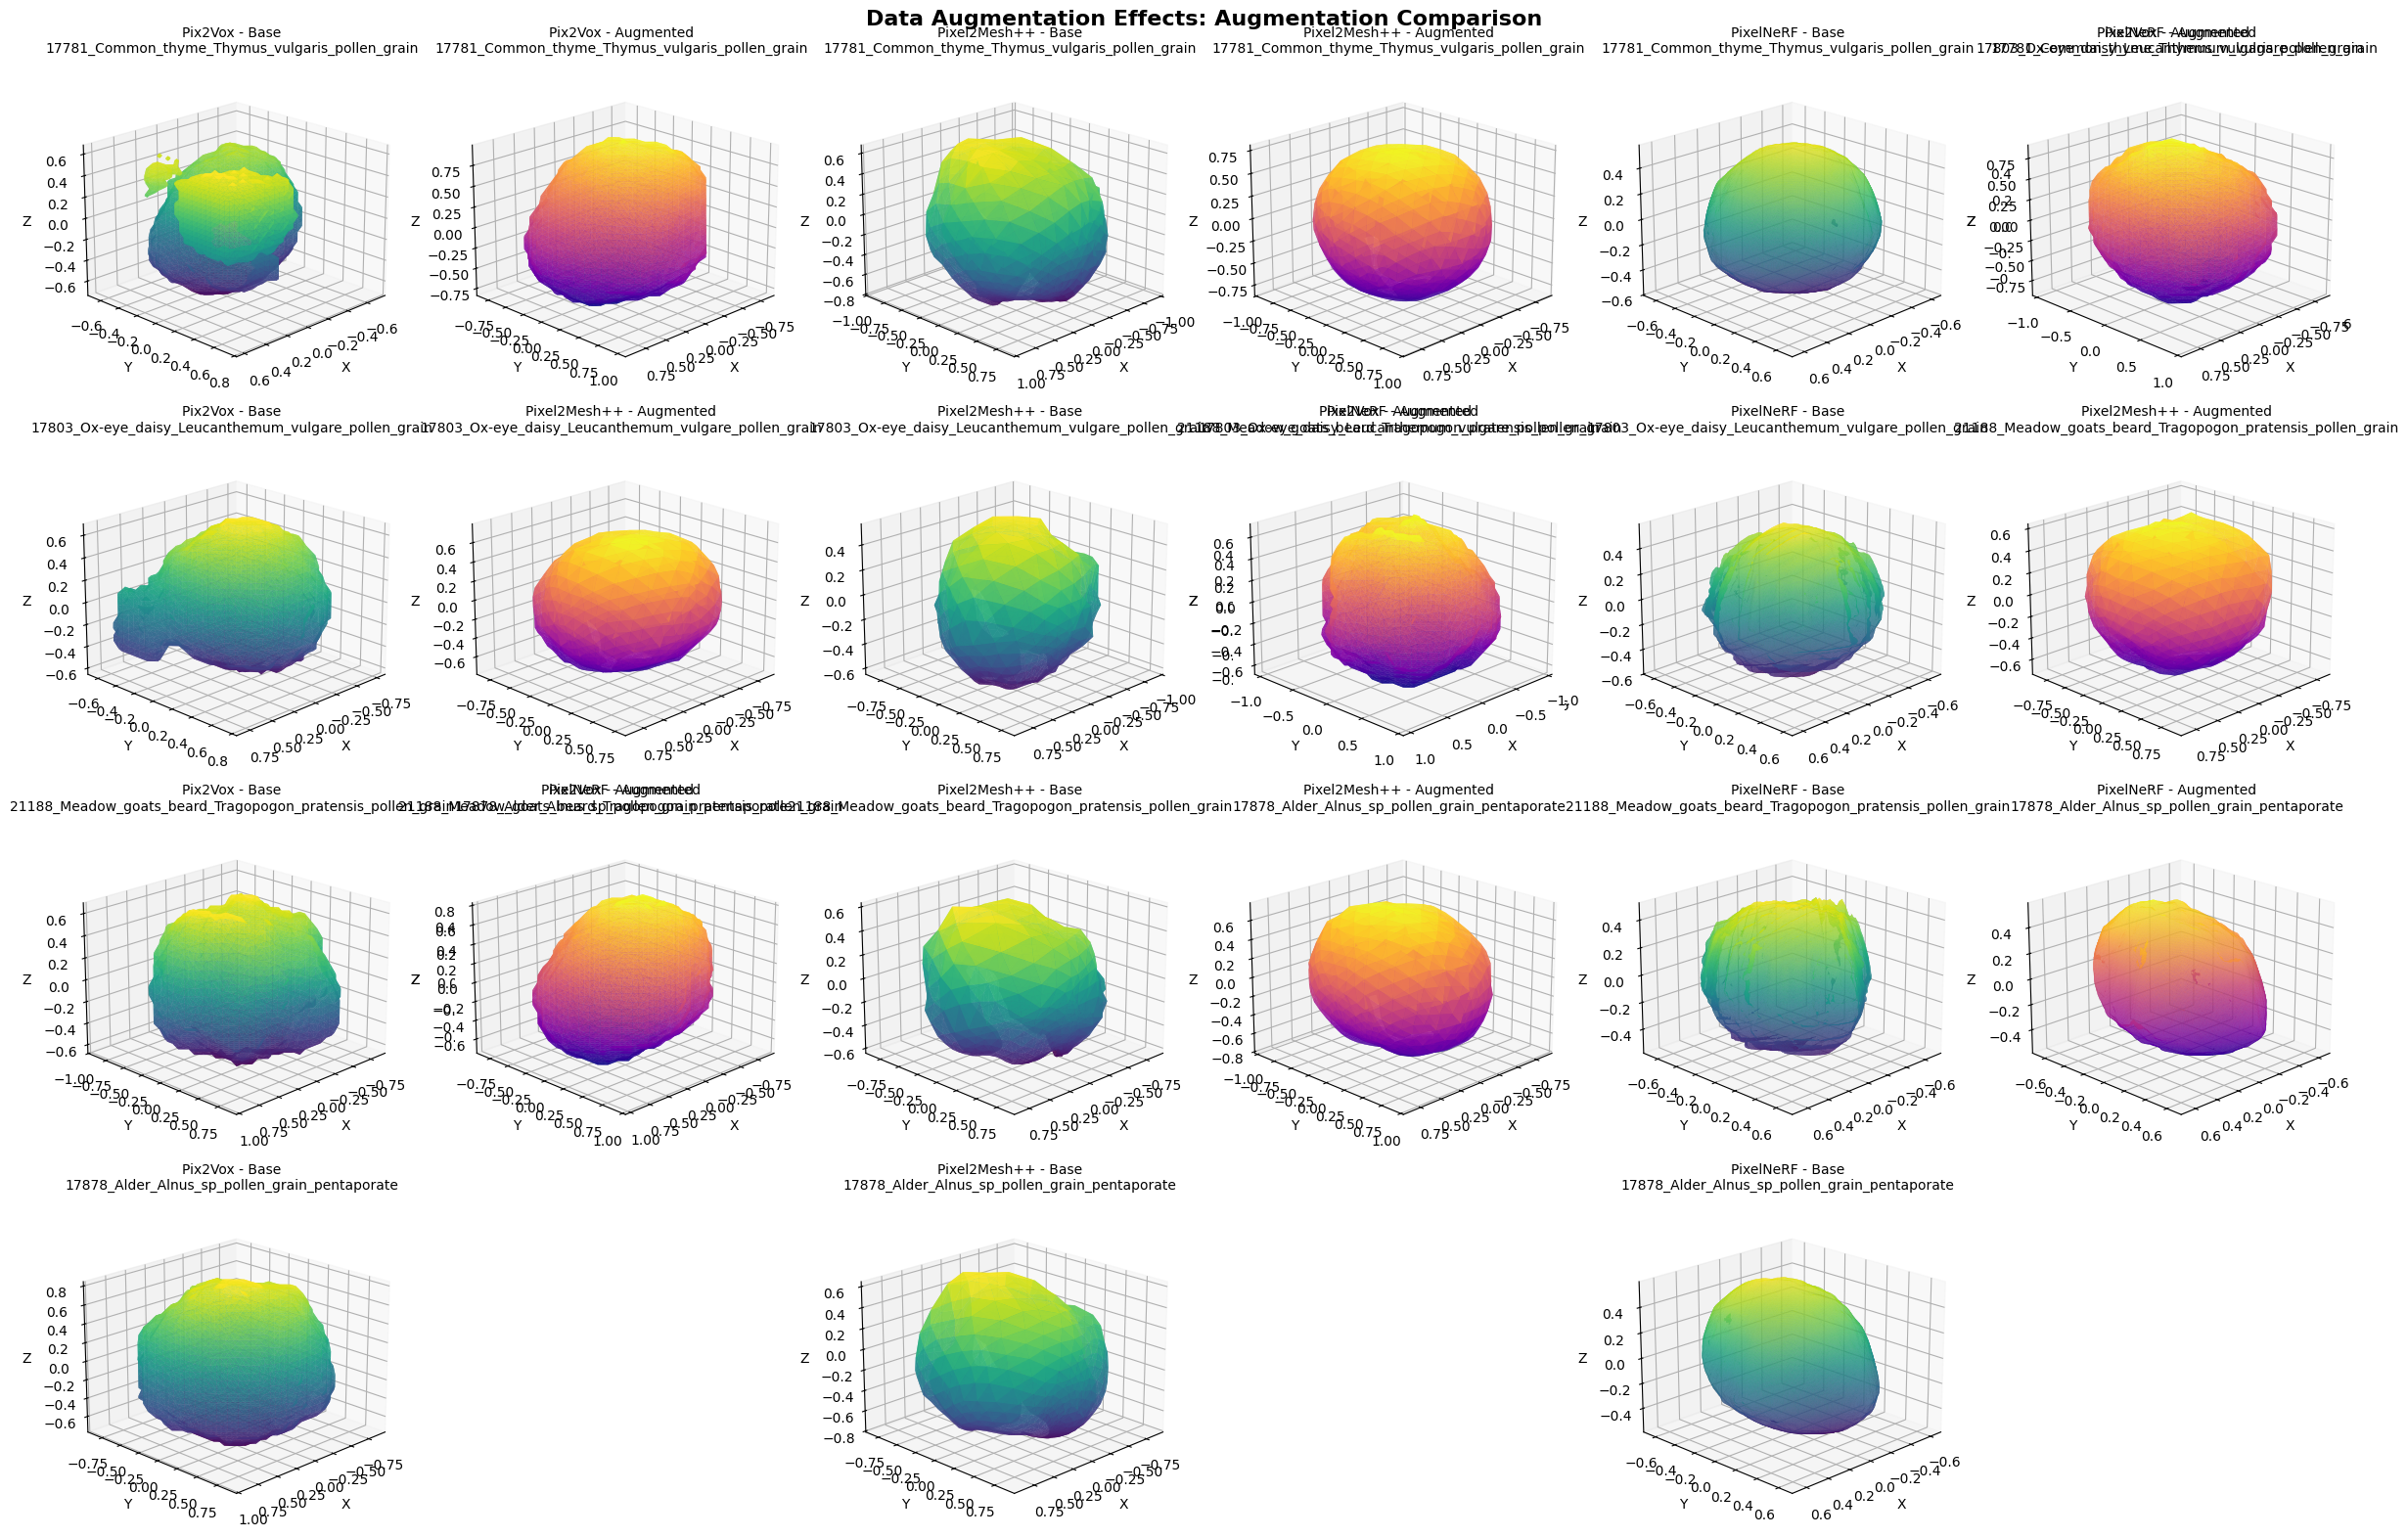


📊 Comparison shows:
  • Left column: Base models (without augmentation)
  • Right column: Augmented models (with data augmentation)
  • Each row: Different pollen grain specimen
  • Colors: viridis (base) vs plasma (augmented) for easy distinction


In [6]:
# Create comprehensive comparison plot
print("🎨 Creating qualitative mesh comparisons...")
print("=" * 60)

# Create the main comparison plot
fig = plot_mesh_comparison(
    mesh_names=test_meshes,
    model_pairs=model_pairs,
    title_prefix="Data Augmentation Effects: ",
    figsize=(24, 16),
)

plt.show()

print("\n📊 Comparison shows:")
print("  • Left column: Base models (without augmentation)")
print("  • Right column: Augmented models (with data augmentation)")
print("  • Each row: Different pollen grain specimen")
print("  • Colors: viridis (base) vs plasma (augmented) for easy distinction")


🔬 Individual Model Comparisons:

📐 Pix2Vox - Base vs Augmented:


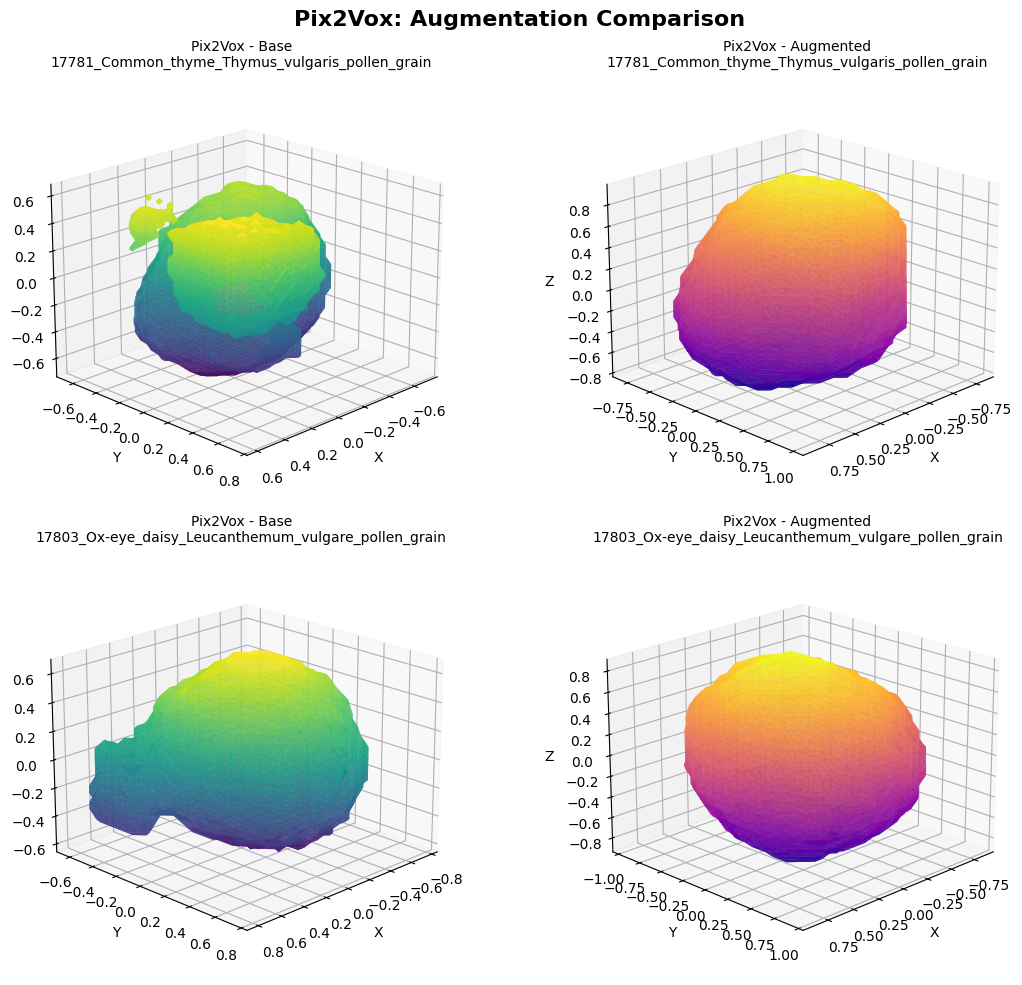

  ✓ Comparing base (pix2vox_base) vs augmented (pix2vox_aug)

📐 Pixel2Mesh++ - Base vs Augmented:


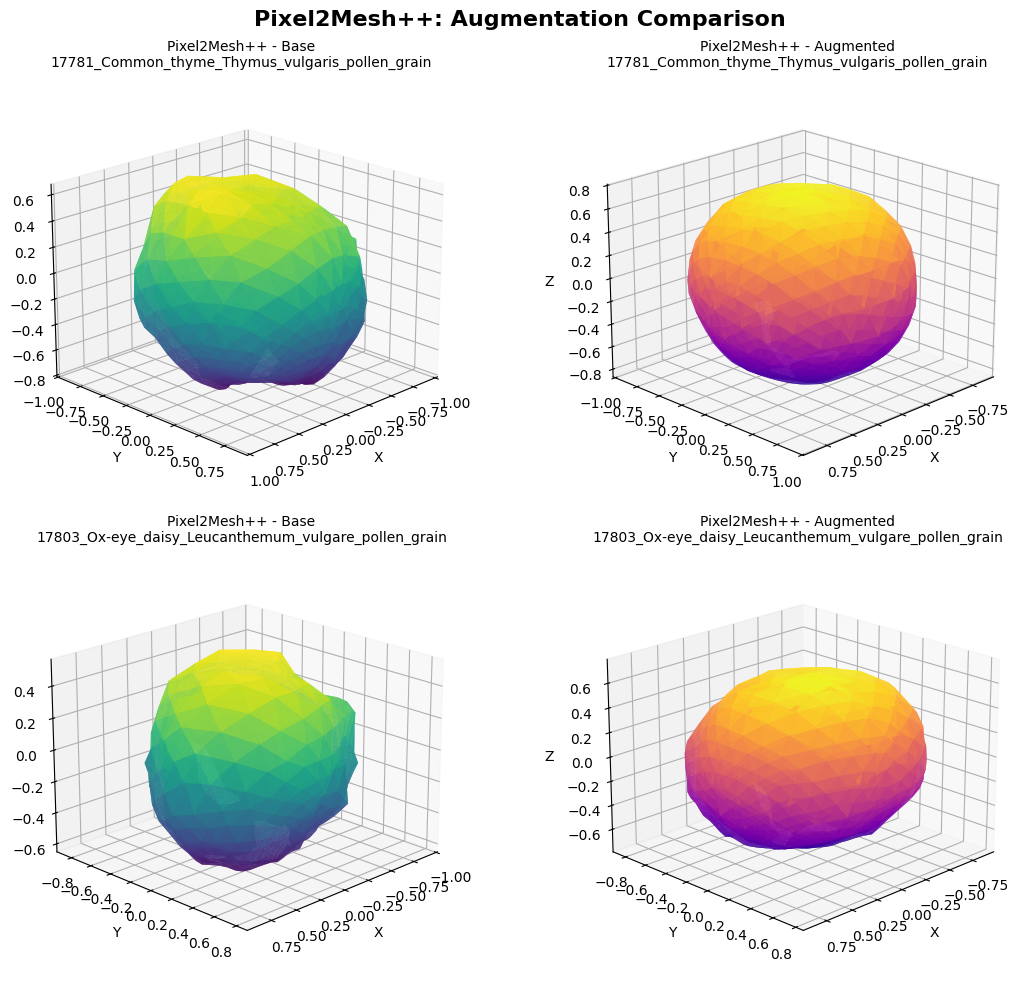

  ✓ Comparing base (refine_p2mpp_2_inputs_none_augmentation) vs augmented (refine_p2mpp_augmentation_2_inputs)

📐 PixelNeRF - Base vs Augmented:


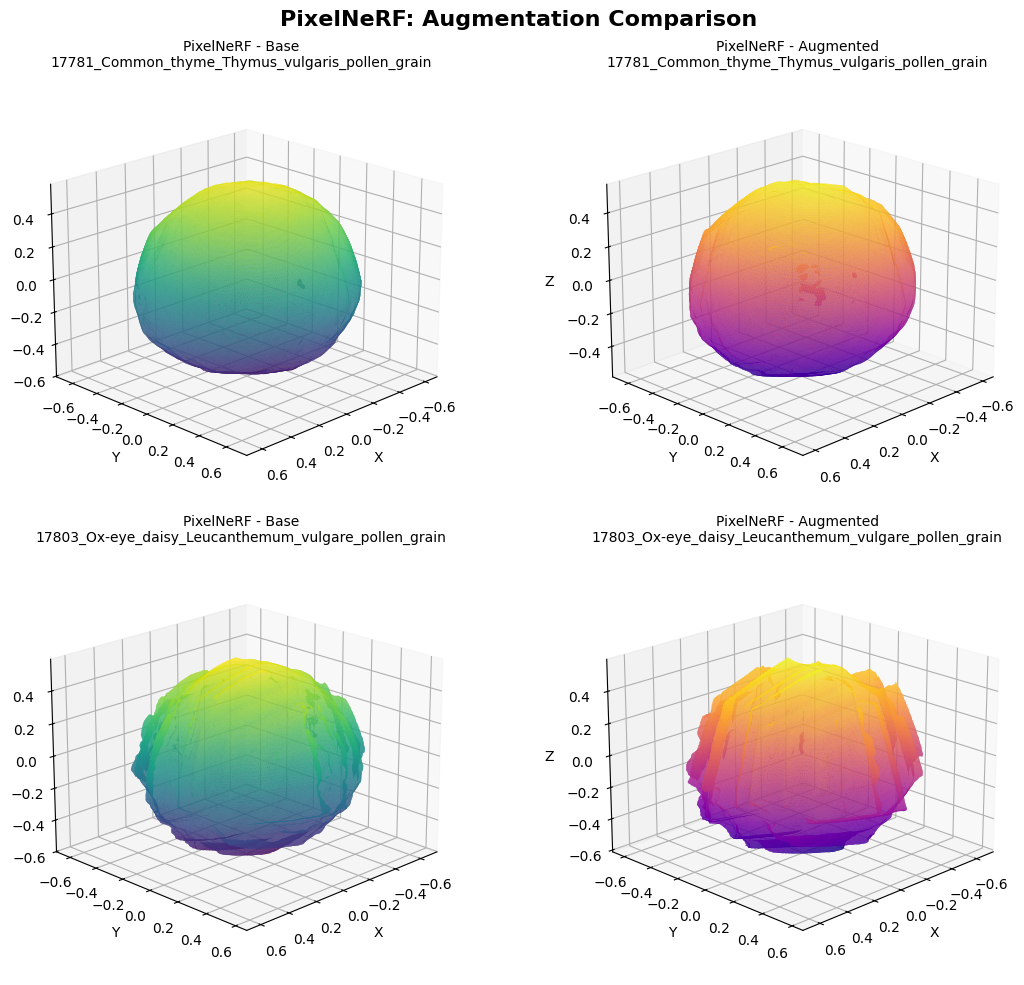

  ✓ Comparing base (pollen_256_2) vs augmented (pollen_augmentation2)


In [7]:
# Create individual comparison plots for each model pair
print("\n🔬 Individual Model Comparisons:")
print("=" * 40)

for pair in model_pairs:
    print(f"\n📐 {pair['name']} - Base vs Augmented:")

    # Create individual plot for this model pair
    fig = plot_mesh_comparison(
        mesh_names=test_meshes[:2],  # Use fewer meshes for cleaner individual plots
        model_pairs=[pair],
        title_prefix=f"{pair['name']}: ",
        figsize=(12, 10),
    )

    plt.show()

    print(
        f"  ✓ Comparing base ({Path(pair['base_dir']).name}) vs augmented ({Path(pair['aug_dir']).name})"
    )


🏆 Ground Truth Comparison:
Comparing: GT | Base | Augmented for each model


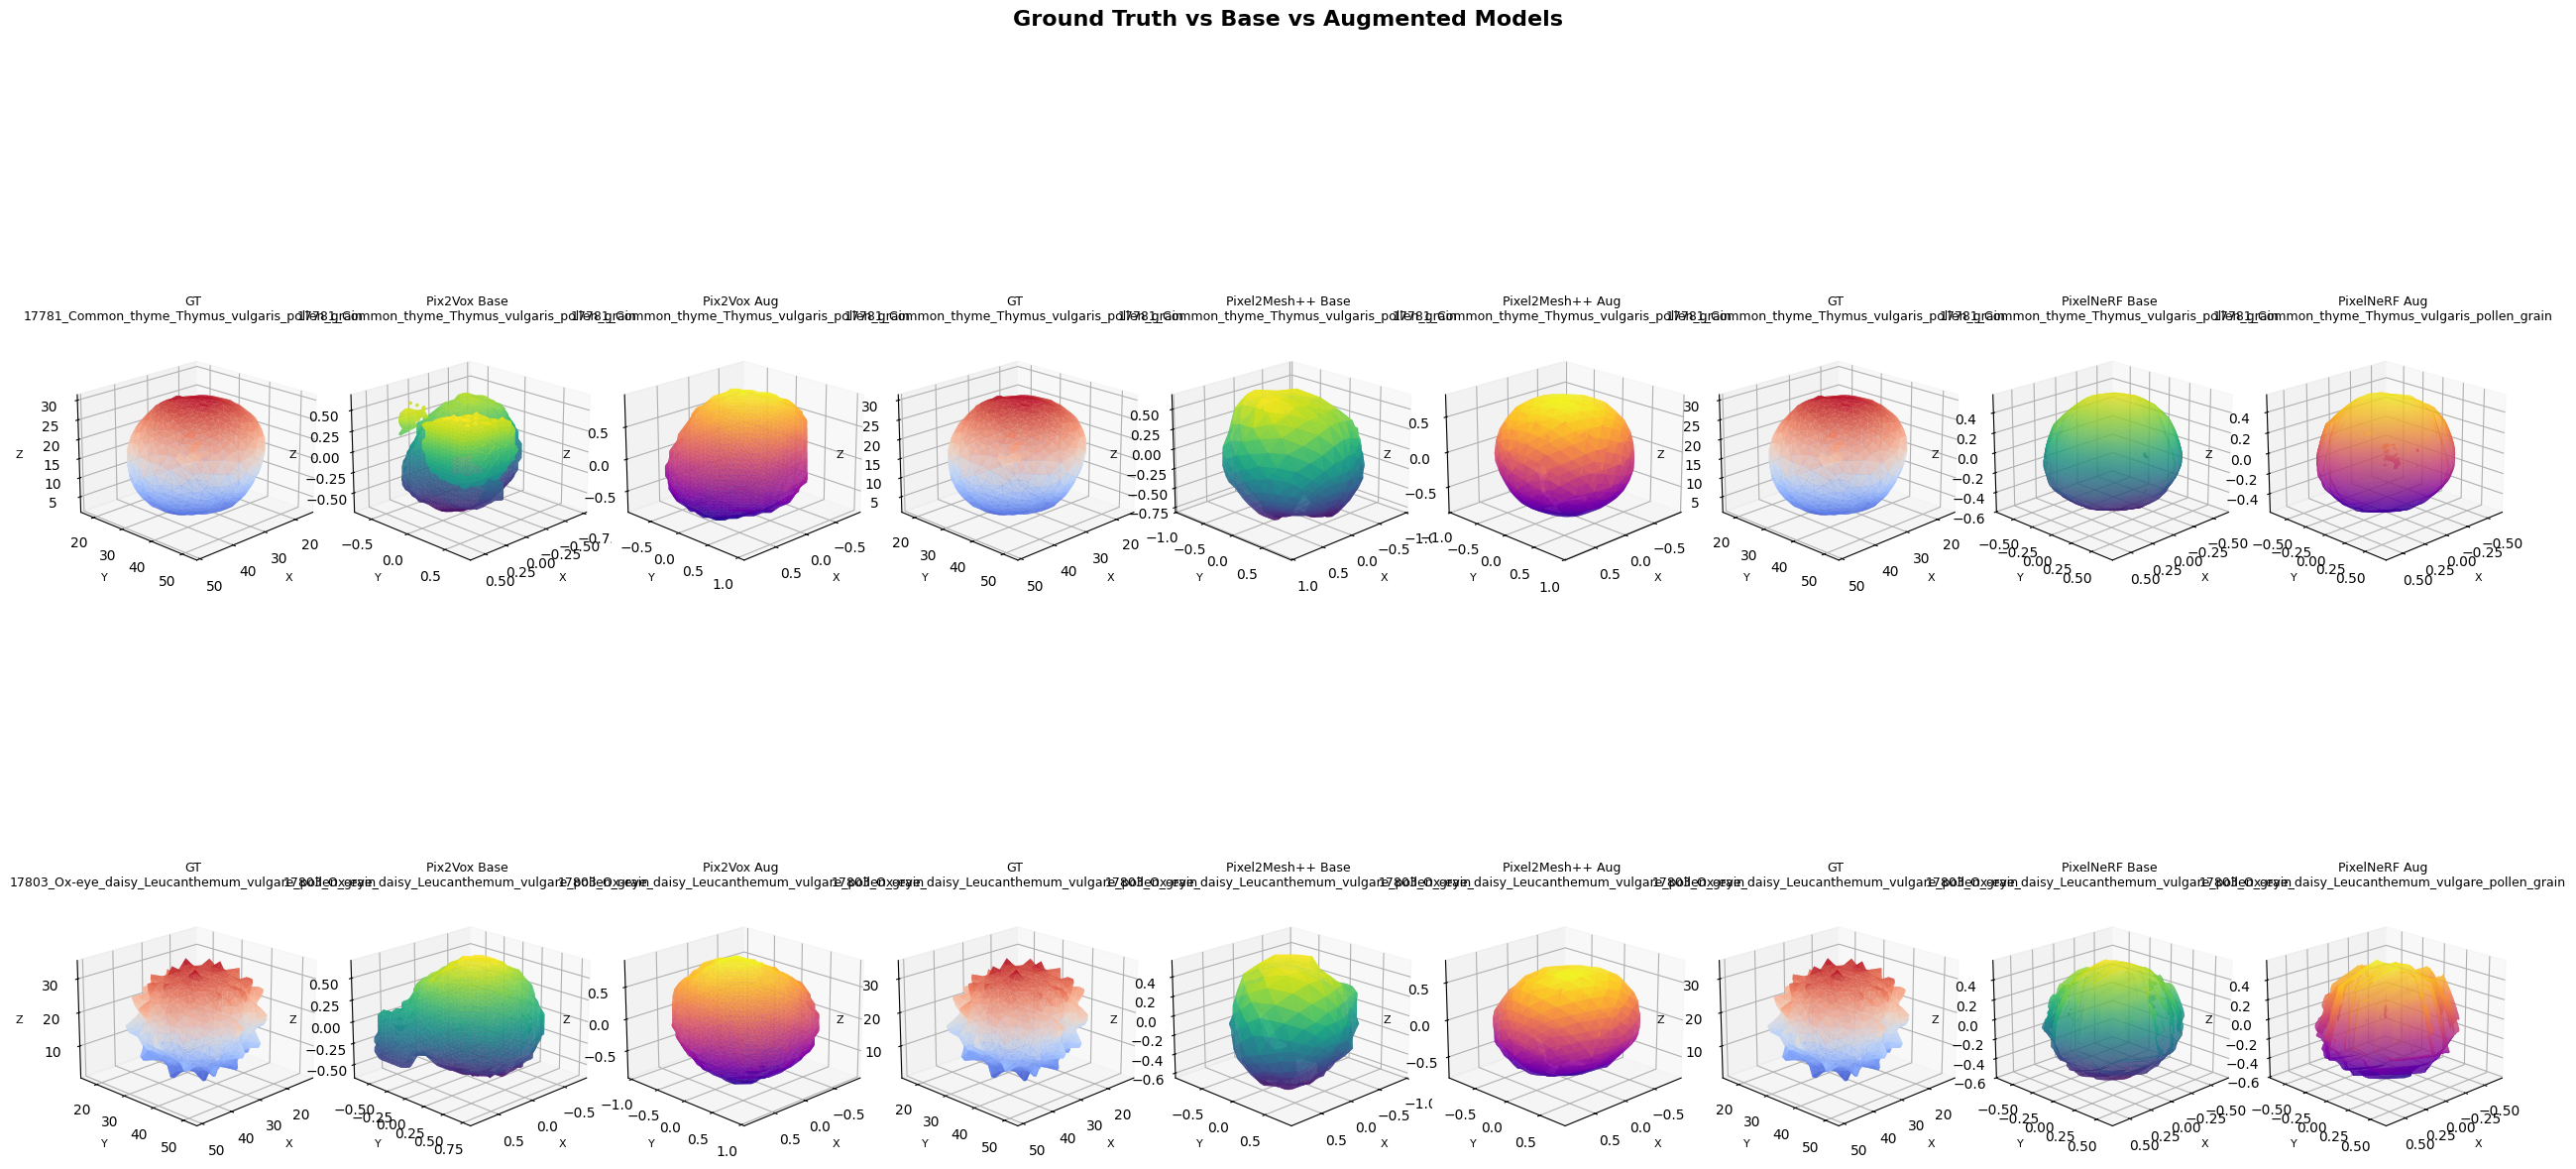


📝 Analysis Guide:
  • Column 1: Ground Truth (target)
  • Column 2: Base model (no augmentation)
  • Column 3: Augmented model (with data augmentation)
  • Compare how augmentation affects similarity to GT


In [8]:
# Enhanced comparison including Ground Truth
def plot_gt_comparison(mesh_names, model_pairs, gt_dir="../data/processed/meshes"):
    """
    Create comparison plot including Ground Truth reference
    GT | Base | Augmented for each model
    """
    n_rows = len(mesh_names)
    n_cols = len(model_pairs) * 3  # GT + Base + Augmented for each model

    fig = plt.figure(figsize=(25, 15))

    for row, mesh_name in enumerate(mesh_names):
        for col_model, pair in enumerate(model_pairs):
            base_col = col_model * 3

            # Ground Truth (first column of triplet)
            ax_gt = fig.add_subplot(
                n_rows, n_cols, row * n_cols + base_col + 1, projection="3d"
            )

            # Base model (second column of triplet)
            ax_base = fig.add_subplot(
                n_rows, n_cols, row * n_cols + base_col + 2, projection="3d"
            )

            # Augmented model (third column of triplet)
            ax_aug = fig.add_subplot(
                n_rows, n_cols, row * n_cols + base_col + 3, projection="3d"
            )

            axes = [ax_gt, ax_base, ax_aug]
            dirs = [gt_dir, pair["base_dir"], pair["aug_dir"]]
            titles = [
                f"GT\n{mesh_name}",
                f"{pair['name']} Base\n{mesh_name}",
                f"{pair['name']} Aug\n{mesh_name}",
            ]
            colors = ["coolwarm", "viridis", "plasma"]

            for ax, mesh_dir, title, color in zip(axes, dirs, titles, colors):
                mesh_path = find_mesh_file(mesh_dir, mesh_name)
                if mesh_path:
                    try:
                        mesh = trimesh.load(mesh_path)
                        ax.plot_trisurf(
                            mesh.vertices[:, 0],
                            mesh.vertices[:, 1],
                            mesh.vertices[:, 2],
                            triangles=mesh.faces,
                            alpha=0.8,
                            cmap=color,
                        )
                        ax.set_title(title, fontsize=9)
                    except Exception as e:
                        ax.text(
                            0.5,
                            0.5,
                            0.5,
                            f"Error\n{mesh_name}",
                            transform=ax.transAxes,
                            ha="center",
                            va="center",
                        )
                else:
                    ax.text(
                        0.5,
                        0.5,
                        0.5,
                        f"Not found\n{mesh_name}",
                        transform=ax.transAxes,
                        ha="center",
                        va="center",
                    )

                # Styling
                ax.set_xlabel("X", fontsize=8)
                ax.set_ylabel("Y", fontsize=8)
                ax.set_zlabel("Z", fontsize=8)
                ax.view_init(elev=20, azim=45)

    plt.suptitle(
        "Ground Truth vs Base vs Augmented Models", fontsize=16, fontweight="bold"
    )
    plt.tight_layout()
    return fig


print("\n🏆 Ground Truth Comparison:")
print("=" * 35)
print("Comparing: GT | Base | Augmented for each model")

# Create GT comparison plot
gt_fig = plot_gt_comparison(
    mesh_names=test_meshes[:2],  # Use 2 meshes for cleaner visualization
    model_pairs=model_pairs,
)

plt.show()

print("\n📝 Analysis Guide:")
print("  • Column 1: Ground Truth (target)")
print("  • Column 2: Base model (no augmentation)")
print("  • Column 3: Augmented model (with data augmentation)")
print("  • Compare how augmentation affects similarity to GT")

🎨 Creating clean augmentation comparison (exp_1_fine_tuning style)...
📋 Comparing 5 meshes for all three models

🔍 Processing 1/5: 17781_Common_thyme_Thymus_vulgaris_pollen_grain
  ✅ Found Pix2Vox files:
     Base: ..\TestEvaluationPipeline\data\pix2vox_base\17781_Common_thyme_Thymus_vulgaris_pollen_grain.stl
     Aug: ..\TestEvaluationPipeline\data\pix2vox_aug\17781_Common_thyme_Thymus_vulgaris_pollen_grain.stl


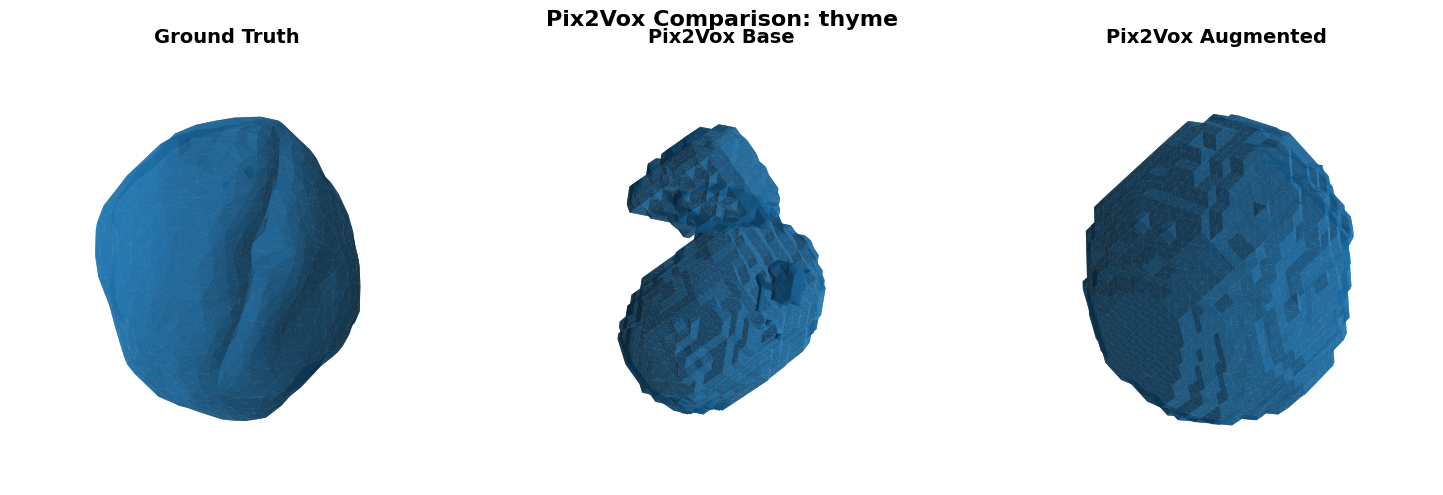

  ✅ Pix2Vox comparison complete for 17781_Common_thyme_Thymus_vulgaris_pollen_grain

🔍 Processing 2/5: 17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain
  ✅ Found Pix2Vox files:
     Base: ..\TestEvaluationPipeline\data\pix2vox_base\17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain.stl
     Aug: ..\TestEvaluationPipeline\data\pix2vox_aug\17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain.stl


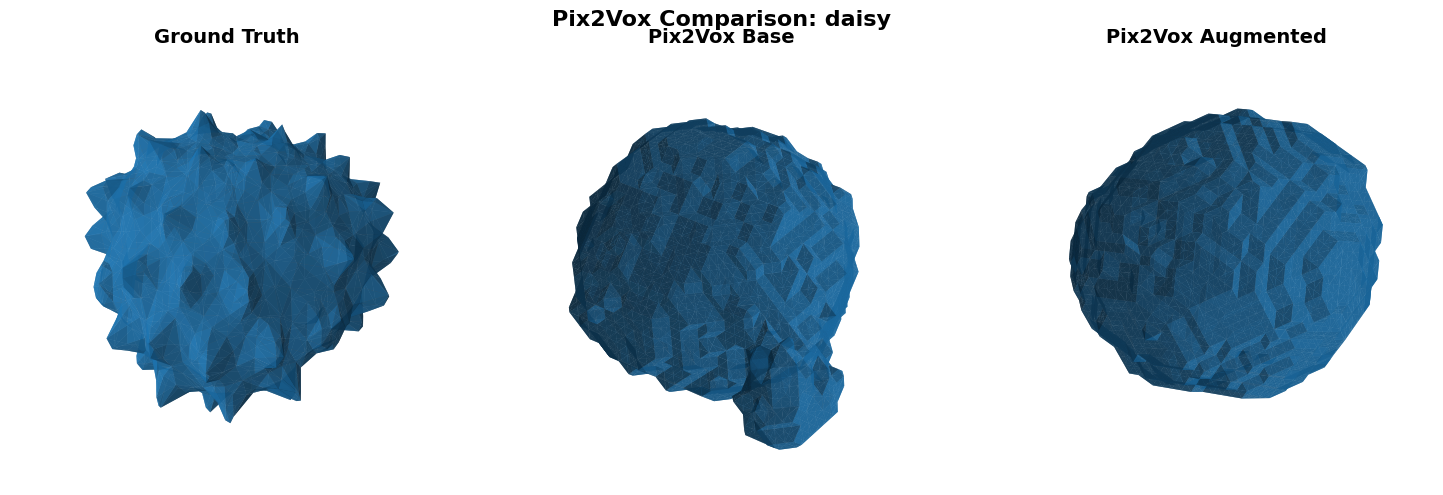

  ✅ Pix2Vox comparison complete for 17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain

🔍 Processing 3/5: 21555_Hard_rush_Juncus_inflexus_pollen_grain_shrunken
  ✅ Found Pix2Vox files:
     Base: ..\TestEvaluationPipeline\data\pix2vox_base\21555_Hard_rush_Juncus_inflexus_pollen_grain_shrunken.stl
     Aug: ..\TestEvaluationPipeline\data\pix2vox_aug\21555_Hard_rush_Juncus_inflexus_pollen_grain_shrunken.stl


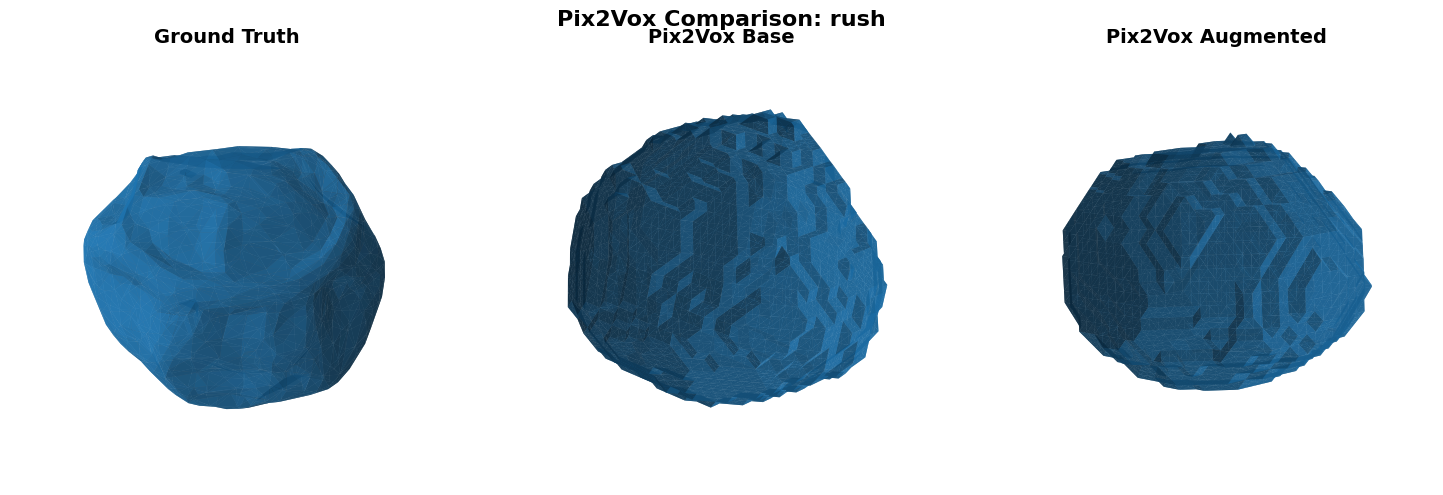

  ✅ Pix2Vox comparison complete for 21555_Hard_rush_Juncus_inflexus_pollen_grain_shrunken

🔍 Processing 4/5: 21188_Meadow_goats_beard_Tragopogon_pratensis_pollen_grain
  ✅ Found Pix2Vox files:
     Base: ..\TestEvaluationPipeline\data\pix2vox_base\21188_Meadow_goats_beard_Tragopogon_pratensis_pollen_grain.stl
     Aug: ..\TestEvaluationPipeline\data\pix2vox_aug\21188_Meadow_goats_beard_Tragopogon_pratensis_pollen_grain.stl


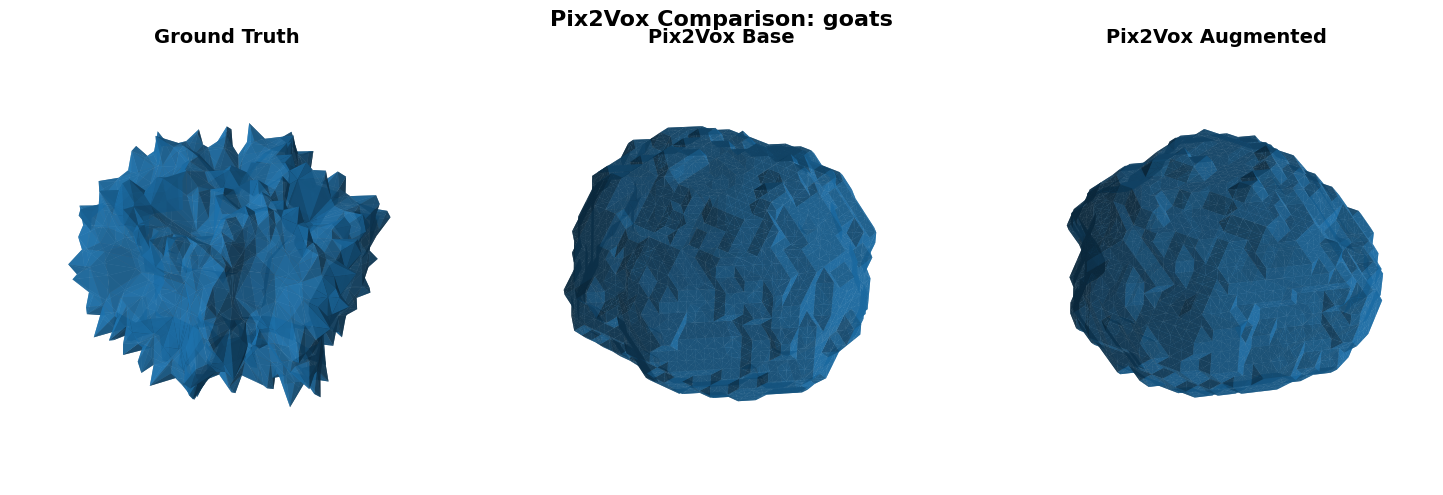

  ✅ Pix2Vox comparison complete for 21188_Meadow_goats_beard_Tragopogon_pratensis_pollen_grain

🔍 Processing 5/5: 17878_Alder_Alnus_sp_pollen_grain_pentaporate
  ✅ Found Pix2Vox files:
     Base: ..\TestEvaluationPipeline\data\pix2vox_base\17878_Alder_Alnus_sp_pollen_grain_pentaporate.stl
     Aug: ..\TestEvaluationPipeline\data\pix2vox_aug\17878_Alder_Alnus_sp_pollen_grain_pentaporate.stl


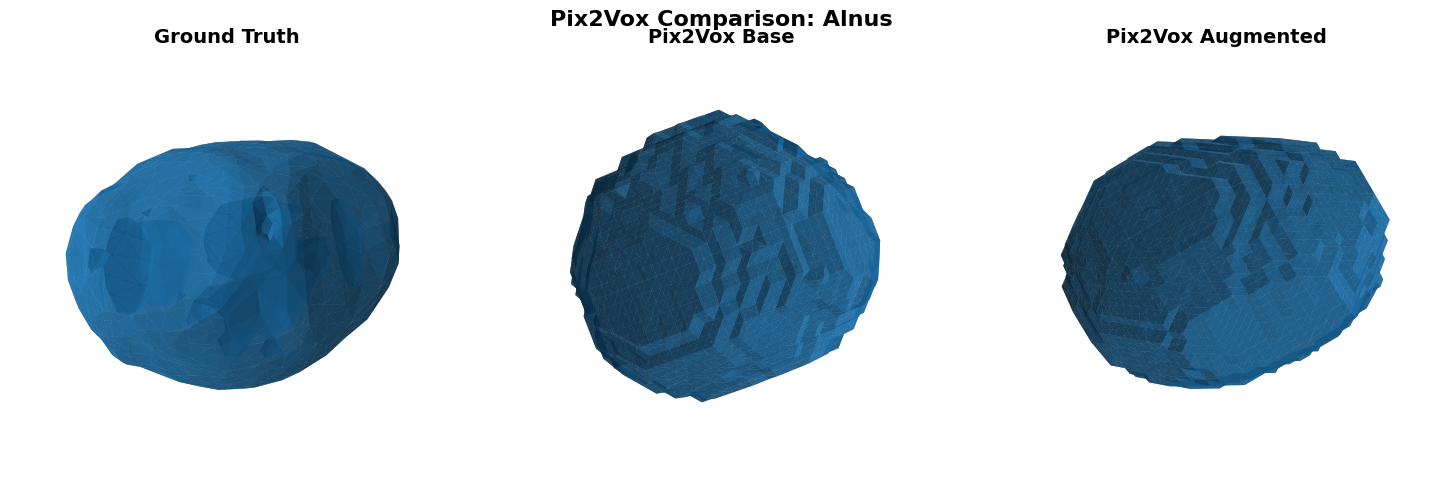

  ✅ Pix2Vox comparison complete for 17878_Alder_Alnus_sp_pollen_grain_pentaporate

🎨 All Pix2Vox comparisons complete!


In [7]:
# Add the same set_axes_equal_and_zoom function from exp_1_fine_tuning
def set_axes_equal_and_zoom(ax, mesh, zoom=1.5):
    # get raw extents
    xyz = mesh.vertices
    x_min, y_min, z_min = xyz.min(axis=0)
    x_max, y_max, z_max = xyz.max(axis=0)
    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2
    z_mid = (z_min + z_max) / 2

    # half‐size of the largest span
    half_size = max(x_max - x_min, y_max - y_min, z_max - z_min) * zoom / 2

    # set equal aspect box, zoomed out by factor zoom
    ax.set_xlim(x_mid - half_size, x_mid + half_size)
    ax.set_ylim(y_mid - half_size, y_mid + half_size)
    ax.set_zlim(z_mid - half_size, z_mid + half_size)

    # optional: force truly equal aspect
    ax.set_box_aspect((1, 1, 1))


# Clean augmentation comparison in the same style as exp_1_fine_tuning
print("🎨 Creating clean augmentation comparison (exp_1_fine_tuning style)...")

# Multiple meshes for comprehensive comparison
filenames = [
    "17781_Common_thyme_Thymus_vulgaris_pollen_grain",
    "17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain",
    "21555_Hard_rush_Juncus_inflexus_pollen_grain_shrunken",
    "21188_Meadow_goats_beard_Tragopogon_pratensis_pollen_grain",
    "17878_Alder_Alnus_sp_pollen_grain_pentaporate",
]

print(f"📋 Comparing {len(filenames)} meshes for all three models")

# Process each mesh
for i, test_mesh in enumerate(filenames):
    print(f"\n🔍 Processing {i+1}/{len(filenames)}: {test_mesh}")

    # Load Ground Truth
    gt = trimesh.load(f"../data/processed/meshes/{test_mesh}.stl")

    # Load Pix2Vox models using find_mesh_file for .obj/.stl flexibility
    pix2vox_base_path = find_mesh_file(
        "../TestEvaluationPipeline/data/pix2vox_base", test_mesh
    )
    pix2vox_aug_path = find_mesh_file(
        "../TestEvaluationPipeline/data/pix2vox_aug", test_mesh
    )

    if pix2vox_base_path and pix2vox_aug_path:
        pix2vox_base = trimesh.load(pix2vox_base_path)
        pix2vox_aug = trimesh.load(pix2vox_aug_path)

        print(f"  ✅ Found Pix2Vox files:")
        print(f"     Base: {pix2vox_base_path}")
        print(f"     Aug: {pix2vox_aug_path}")
    else:
        print(f"  ⚠️ Pix2Vox files not found - skipping {test_mesh}")
        continue

    # Align both to GT
    base_aligned, _ = MeshUtils.align_icp(pix2vox_base, gt)
    aug_aligned, _ = MeshUtils.align_icp(pix2vox_aug, gt)

    # Rebuild meshes with aligned vertices
    base_rebuilt = trimesh.Trimesh(
        vertices=base_aligned.vertices, faces=pix2vox_base.faces
    )
    aug_rebuilt = trimesh.Trimesh(
        vertices=aug_aligned.vertices, faces=pix2vox_aug.faces
    )

    # Create the plot in exp_1_fine_tuning style
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131, projection="3d")
    ax2 = fig.add_subplot(132, projection="3d")
    ax3 = fig.add_subplot(133, projection="3d")

    # Apply the same styling as exp_1_fine_tuning
    for ax in (ax1, ax2, ax3):
        ax.grid(False)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor("none")
        ax.yaxis.pane.set_edgecolor("none")
        ax.zaxis.pane.set_edgecolor("none")
        ax.set_axis_off()

    # Set titles with mesh name
    ax1.set_title("Ground Truth", fontsize=14, fontweight="bold")
    ax2.set_title("Pix2Vox Base", fontsize=14, fontweight="bold")
    ax3.set_title("Pix2Vox Augmented", fontsize=14, fontweight="bold")

    # Plot meshes with same blue style
    ax1.plot_trisurf(
        gt.vertices[:, 0],
        gt.vertices[:, 1],
        gt.vertices[:, 2],
        triangles=gt.faces,
        alpha=0.8,
    )
    ax2.plot_trisurf(
        base_rebuilt.vertices[:, 0],
        base_rebuilt.vertices[:, 1],
        base_rebuilt.vertices[:, 2],
        triangles=base_rebuilt.faces,
        alpha=0.8,
    )
    ax3.plot_trisurf(
        aug_rebuilt.vertices[:, 0],
        aug_rebuilt.vertices[:, 1],
        aug_rebuilt.vertices[:, 2],
        triangles=aug_rebuilt.faces,
        alpha=0.8,
    )

    # Apply same zoom and aspect ratio
    set_axes_equal_and_zoom(ax1, gt, zoom=0.8)
    set_axes_equal_and_zoom(ax2, base_rebuilt, zoom=0.8)
    set_axes_equal_and_zoom(ax3, aug_rebuilt, zoom=0.8)

    # Add overall title with mesh name
    plt.suptitle(
        f"Pix2Vox Comparison: {test_mesh.split('_')[2]}", fontsize=16, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()

    print(f"  ✅ Pix2Vox comparison complete for {test_mesh}")

print("\n🎨 All Pix2Vox comparisons complete!")

In [10]:
# PixelNeRF Augmentation Comparison for all meshes
print("\n🧬 PixelNeRF: Base vs Augmented for all meshes")

for i, test_mesh in enumerate(filenames):
    print(f"\n🔍 Processing PixelNeRF {i+1}/{len(filenames)}: {test_mesh}")

    # Load Ground Truth
    gt = trimesh.load(f"../data/processed/meshes/{test_mesh}.stl")

    try:
        # Load PixelNeRF models using find_mesh_file for .obj/.stl flexibility
        pixelnerf_base_path = find_mesh_file(
            "../TestEvaluationPipeline/data/pollen_256_2", test_mesh
        )
        pixelnerf_aug_path = find_mesh_file(
            "../TestEvaluationPipeline/data/pollen_augmentation2", test_mesh
        )

        if pixelnerf_base_path and pixelnerf_aug_path:
            pixelnerf_base = trimesh.load(pixelnerf_base_path)
            pixelnerf_aug = trimesh.load(pixelnerf_aug_path)

            # Align to GT
            nerf_base_aligned, _ = MeshUtils.align_icp(pixelnerf_base, gt)
            nerf_aug_aligned, _ = MeshUtils.align_icp(pixelnerf_aug, gt)

            # Rebuild
            nerf_base_rebuilt = trimesh.Trimesh(
                vertices=nerf_base_aligned.vertices, faces=pixelnerf_base.faces
            )
            nerf_aug_rebuilt = trimesh.Trimesh(
                vertices=nerf_aug_aligned.vertices, faces=pixelnerf_aug.faces
            )

            # Plot
            fig = plt.figure(figsize=(15, 5))
            ax1 = fig.add_subplot(131, projection="3d")
            ax2 = fig.add_subplot(132, projection="3d")
            ax3 = fig.add_subplot(133, projection="3d")

            # Same styling
            for ax in (ax1, ax2, ax3):
                ax.grid(False)
                ax.xaxis.pane.fill = False
                ax.yaxis.pane.fill = False
                ax.zaxis.pane.fill = False
                ax.xaxis.pane.set_edgecolor("none")
                ax.yaxis.pane.set_edgecolor("none")
                ax.zaxis.pane.set_edgecolor("none")
                ax.set_axis_off()

            ax1.set_title("Ground Truth", fontsize=14, fontweight="bold")
            ax2.set_title("PixelNeRF Base", fontsize=14, fontweight="bold")
            ax3.set_title("PixelNeRF Augmented", fontsize=14, fontweight="bold")

            ax1.plot_trisurf(
                gt.vertices[:, 0],
                gt.vertices[:, 1],
                gt.vertices[:, 2],
                triangles=gt.faces,
                alpha=0.8,
            )
            ax2.plot_trisurf(
                nerf_base_rebuilt.vertices[:, 0],
                nerf_base_rebuilt.vertices[:, 1],
                nerf_base_rebuilt.vertices[:, 2],
                triangles=nerf_base_rebuilt.faces,
                alpha=0.8,
            )
            ax3.plot_trisurf(
                nerf_aug_rebuilt.vertices[:, 0],
                nerf_aug_rebuilt.vertices[:, 1],
                nerf_aug_rebuilt.vertices[:, 2],
                triangles=nerf_aug_rebuilt.faces,
                alpha=0.8,
            )

            set_axes_equal_and_zoom(ax1, gt, zoom=0.8)
            set_axes_equal_and_zoom(ax2, nerf_base_rebuilt, zoom=0.8)
            set_axes_equal_and_zoom(ax3, nerf_aug_rebuilt, zoom=0.8)

            plt.suptitle(
                f"PixelNeRF Comparison: {test_mesh.split('_')[2]}",
                fontsize=16,
                fontweight="bold",
            )
            plt.tight_layout()
            plt.show()
            print(f"  ✅ PixelNeRF comparison complete for {test_mesh}")
        else:
            print(f"  ⚠️ PixelNeRF files not found for {test_mesh}:")
            print(f"     Base: {pixelnerf_base_path}")
            print(f"     Aug: {pixelnerf_aug_path}")

    except Exception as e:
        print(f"  ⚠️ PixelNeRF comparison failed for {test_mesh}: {e}")

print("\n🧬 All PixelNeRF comparisons complete!")

# Pixel2Mesh++ Augmentation Comparison for all meshes
print("\n🔺 Pixel2Mesh++: Base vs Augmented for all meshes")

for i, test_mesh in enumerate(filenames):
    print(f"\n🔍 Processing Pixel2Mesh++ {i+1}/{len(filenames)}: {test_mesh}")

    # Load Ground Truth
    gt = trimesh.load(f"../data/processed/meshes/{test_mesh}.stl")

    try:
        # Load Pixel2Mesh++ models using find_mesh_file for .obj/.stl flexibility
        p2mpp_base_path = find_mesh_file(
            "../TestEvaluationPipeline/data/refine_p2mpp_2_inputs_none_augmentation",
            test_mesh,
        )
        p2mpp_aug_path = find_mesh_file(
            "../TestEvaluationPipeline/data/refine_p2mpp_augmentation_2_inputs",
            test_mesh,
        )

        if p2mpp_base_path and p2mpp_aug_path:
            p2mpp_base = trimesh.load(p2mpp_base_path)
            p2mpp_aug = trimesh.load(p2mpp_aug_path)

            # Align to GT
            p2mpp_base_aligned, _ = MeshUtils.align_icp(p2mpp_base, gt)
            p2mpp_aug_aligned, _ = MeshUtils.align_icp(p2mpp_aug, gt)

            # Rebuild
            p2mpp_base_rebuilt = trimesh.Trimesh(
                vertices=p2mpp_base_aligned.vertices, faces=p2mpp_base.faces
            )
            p2mpp_aug_rebuilt = trimesh.Trimesh(
                vertices=p2mpp_aug_aligned.vertices, faces=p2mpp_aug.faces
            )

            # Plot
            fig = plt.figure(figsize=(15, 5))
            ax1 = fig.add_subplot(131, projection="3d")
            ax2 = fig.add_subplot(132, projection="3d")
            ax3 = fig.add_subplot(133, projection="3d")

            # Same styling
            for ax in (ax1, ax2, ax3):
                ax.grid(False)
                ax.xaxis.pane.fill = False
                ax.yaxis.pane.fill = False
                ax.zaxis.pane.fill = False
                ax.xaxis.pane.set_edgecolor("none")
                ax.yaxis.pane.set_edgecolor("none")
                ax.zaxis.pane.set_edgecolor("none")
                ax.set_axis_off()

            ax1.set_title("Ground Truth", fontsize=14, fontweight="bold")
            ax2.set_title("Pixel2Mesh++ Base", fontsize=14, fontweight="bold")
            ax3.set_title("Pixel2Mesh++ Augmented", fontsize=14, fontweight="bold")

            ax1.plot_trisurf(
                gt.vertices[:, 0],
                gt.vertices[:, 1],
                gt.vertices[:, 2],
                triangles=gt.faces,
                alpha=0.8,
            )
            ax2.plot_trisurf(
                p2mpp_base_rebuilt.vertices[:, 0],
                p2mpp_base_rebuilt.vertices[:, 1],
                p2mpp_base_rebuilt.vertices[:, 2],
                triangles=p2mpp_base_rebuilt.faces,
                alpha=0.8,
            )
            ax3.plot_trisurf(
                p2mpp_aug_rebuilt.vertices[:, 0],
                p2mpp_aug_rebuilt.vertices[:, 1],
                p2mpp_aug_rebuilt.vertices[:, 2],
                triangles=p2mpp_aug_rebuilt.faces,
                alpha=0.8,
            )

            set_axes_equal_and_zoom(ax1, gt, zoom=0.8)
            set_axes_equal_and_zoom(ax2, p2mpp_base_rebuilt, zoom=0.8)
            set_axes_equal_and_zoom(ax3, p2mpp_aug_rebuilt, zoom=0.8)

            plt.suptitle(
                f"Pixel2Mesh++ Comparison: {test_mesh.split('_')[2]}",
                fontsize=16,
                fontweight="bold",
            )
            plt.tight_layout()
            plt.show()
            print(f"  ✅ Pixel2Mesh++ comparison complete for {test_mesh}")
        else:
            print(f"  ⚠️ Pixel2Mesh++ files not found for {test_mesh}:")
            print(f"     Base: {p2mpp_base_path}")
            print(f"     Aug: {p2mpp_aug_path}")

    except Exception as e:
        print(f"  ⚠️ Pixel2Mesh++ comparison failed for {test_mesh}: {e}")

print("\n🔺 All Pixel2Mesh++ comparisons complete!")

print(f"\n📋 All comparisons completed for {len(filenames)} meshes:")
for i, mesh in enumerate(filenames, 1):
    print(f"  {i}. {mesh.split('_')[2]} ({mesh.split('_')[3]})")

print(
    "\n🎨 Style: Clean blue surfaces with transparent background (exp_1_fine_tuning style)"
)
print("🔄 All meshes aligned to Ground Truth using ICP for fair comparison")
print("📊 Models: Pix2Vox, PixelNeRF, Pixel2Mesh++ (Base vs Augmented)")


🧬 PixelNeRF: Base vs Augmented for all meshes

🔍 Processing PixelNeRF 1/5: 17781_Common_thyme_Thymus_vulgaris_pollen_grain


KeyboardInterrupt: 

🎨 Creating a single grid visualization for all models...
📊 Layout: 5 meshes × (GT | Model 1 [Base/Aug] | Model 2 [Base/Aug] | ...)

🔍 Generating combined comparison grid...
  Row 1/5: thyme
  Row 2/5: daisy
  Row 3/5: rush
  Row 4/5: goats
  Row 5/5: Alnus


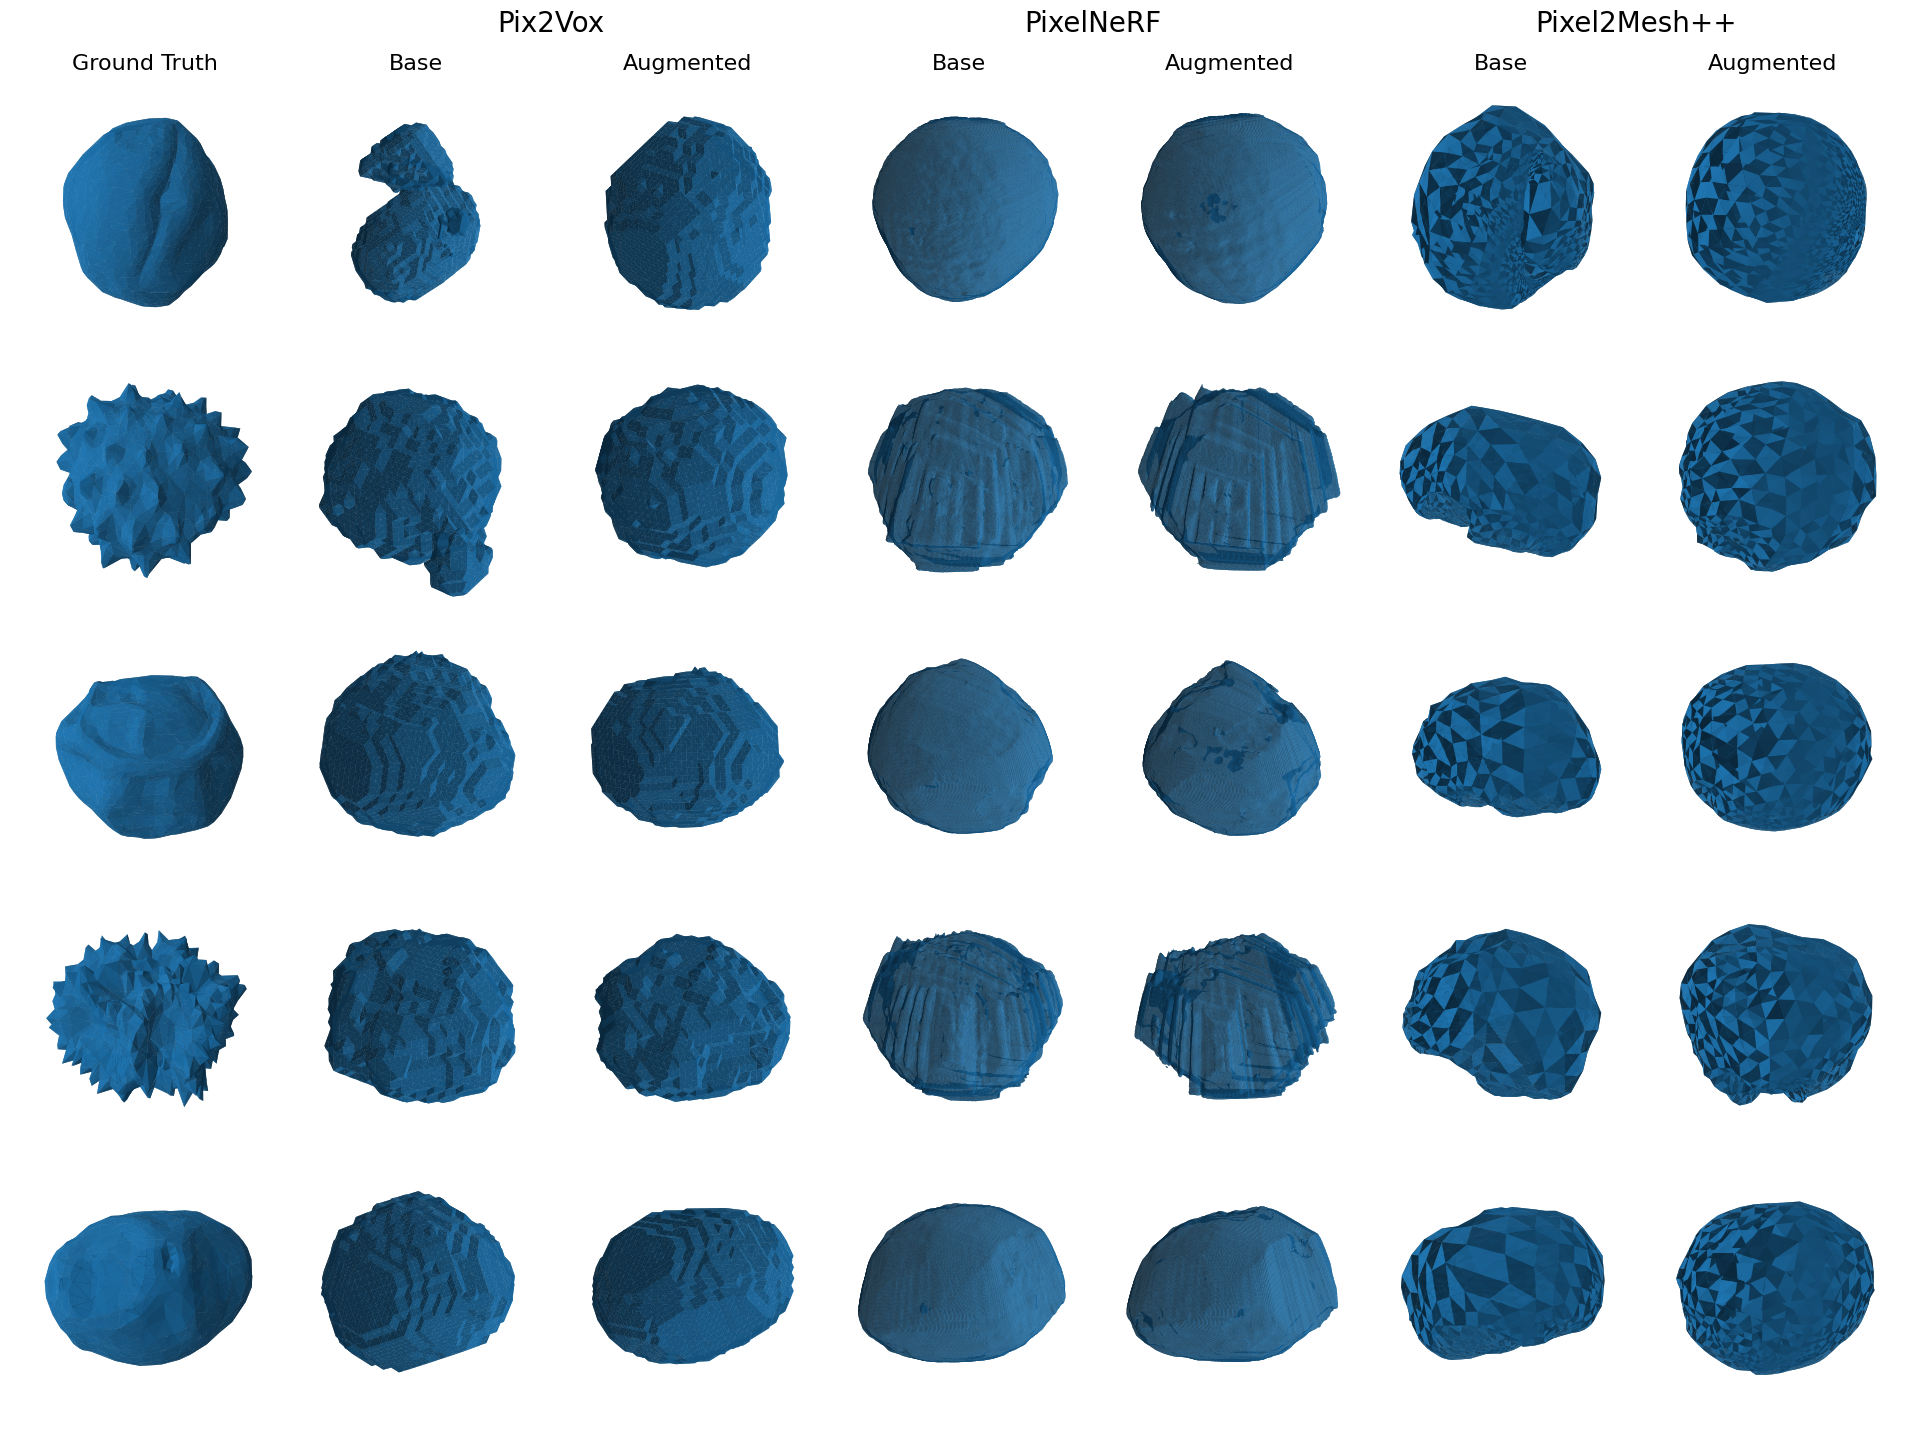


✅ Combined model grid complete!
🔄 All meshes were ICP-aligned to their respective Ground Truth for consistent comparison.


In [18]:
# Combined Grid Visualization: GT and all models
print("🎨 Creating a single grid visualization for all models...")
print(
    "📊 Layout: 5 meshes × (GT | Model 1 [Base/Aug] | Model 2 [Base/Aug] | ...)"
)

# Model configurations
models = [
    {
        "name": "Pix2Vox",
        "base_dir": "../TestEvaluationPipeline/data/pix2vox_base",
        "aug_dir": "../TestEvaluationPipeline/data/pix2vox_aug",
    },
    {
        "name": "PixelNeRF",
        "base_dir": "../TestEvaluationPipeline/data/pollen_256_2",
        "aug_dir": "../TestEvaluationPipeline/data/pollen_augmentation2",
    },
    {
        "name": "Pixel2Mesh++",
        "base_dir": "../TestEvaluationPipeline/data/refine_p2mpp_2_inputs_none_augmentation",
        "aug_dir": "../TestEvaluationPipeline/data/refine_p2mpp_augmentation_2_inputs",
    },
]

# Define mesh names
filenames_grid = [
    "17781_Common_thyme_Thymus_vulgaris_pollen_grain",
    "17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain",
    "21555_Hard_rush_Juncus_inflexus_pollen_grain_shrunken",
    "21188_Meadow_goats_beard_Tragopogon_pratensis_pollen_grain",
    "17878_Alder_Alnus_sp_pollen_grain_pentaporate",
]

# --- Plotting Setup ---
n_rows = len(filenames_grid)
n_models = len(models)
n_fixed_cols = 1  # Just GT
n_model_sub_cols = 2  # Base and Augmented
n_cols = n_fixed_cols + n_models * n_model_sub_cols

# Create a single large figure
fig = plt.figure(figsize=(n_cols * 3.5, n_rows * 3.5))

# --- Grid Generation ---
print("\n🔍 Generating combined comparison grid...")
for row_idx, test_mesh in enumerate(filenames_grid):
    print(f"  Row {row_idx + 1}/{n_rows}: {test_mesh.split('_')[2]}")

    # Load Ground Truth once per row
    gt_mesh = trimesh.load(f"../data/processed/meshes/{test_mesh}.stl")

    # --- Plot GT (First column) ---
    ax_gt = fig.add_subplot(n_rows, n_cols, row_idx * n_cols + 1, projection="3d")

    # --- Styling and Headers for Fixed Columns ---
    ax_gt.grid(False)
    ax_gt.xaxis.pane.fill = False
    ax_gt.yaxis.pane.fill = False
    ax_gt.zaxis.pane.fill = False
    ax_gt.xaxis.pane.set_edgecolor("none")
    ax_gt.yaxis.pane.set_edgecolor("none")
    ax_gt.zaxis.pane.set_edgecolor("none")
    ax_gt.set_axis_off()

    if row_idx == 0:
        ax_gt.set_title("Ground Truth", fontsize=16)

    # --- Plotting GT Mesh ---
    ax_gt.plot_trisurf(
        gt_mesh.vertices[:, 0], gt_mesh.vertices[:, 1], gt_mesh.vertices[:, 2],
        triangles=gt_mesh.faces, alpha=0.9
    )
    set_axes_equal_and_zoom(ax_gt, gt_mesh, zoom=0.8)

    # --- Loop Through Models (Remaining columns) ---
    for model_idx, model in enumerate(models):
        # --- Subplot Position Calculation ---
        base_col_idx = n_fixed_cols + model_idx * n_model_sub_cols
        aug_col_idx = base_col_idx + 1
        base_pos = row_idx * n_cols + base_col_idx + 1
        aug_pos = row_idx * n_cols + aug_col_idx + 1

        # --- Subplot Creation ---
        ax_base = fig.add_subplot(n_rows, n_cols, base_pos, projection="3d")
        ax_aug = fig.add_subplot(n_rows, n_cols, aug_pos, projection="3d")

        # --- Styling ---
        for ax in [ax_base, ax_aug]:
            ax.grid(False)
            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False
            ax.xaxis.pane.set_edgecolor("none")
            ax.yaxis.pane.set_edgecolor("none")
            ax.zaxis.pane.set_edgecolor("none")
            ax.set_axis_off()

        # --- Headers for Model Columns (Top Row) ---
        if row_idx == 0:
            # Model name header, centered over the two sub-columns
            ax_base.text2D(
                1.0, 1.15, model["name"], transform=ax_base.transAxes,
                ha="center", va="bottom", fontsize=20
            )
            # Sub-column headers
            ax_base.set_title("Base", fontsize=16)
            ax_aug.set_title("Augmented", fontsize=16)

        # --- Plotting Base and Augmented Meshes ---
        base_path = find_mesh_file(model["base_dir"], test_mesh)
        if base_path:
            try:
                base_mesh = trimesh.load(base_path)
                base_aligned, _ = MeshUtils.align_icp(base_mesh, gt_mesh)
                base_rebuilt = trimesh.Trimesh(vertices=base_aligned.vertices, faces=base_mesh.faces)
                ax_base.plot_trisurf(
                    base_rebuilt.vertices[:, 0], base_rebuilt.vertices[:, 1], base_rebuilt.vertices[:, 2],
                    triangles=base_rebuilt.faces, alpha=0.9
                )
                set_axes_equal_and_zoom(ax_base, base_rebuilt, zoom=0.8)
            except Exception as e:
                ax_base.text(0.5, 0.5, 0.5, "Error", transform=ax_base.transAxes, ha="center", va="center")
        else:
            ax_base.text(0.5, 0.5, 0.5, "Not found", transform=ax_base.transAxes, ha="center", va="center")

        aug_path = find_mesh_file(model["aug_dir"], test_mesh)
        if aug_path:
            try:
                aug_mesh = trimesh.load(aug_path)
                aug_aligned, _ = MeshUtils.align_icp(aug_mesh, gt_mesh)
                aug_rebuilt = trimesh.Trimesh(vertices=aug_aligned.vertices, faces=aug_mesh.faces)
                ax_aug.plot_trisurf(
                    aug_rebuilt.vertices[:, 0], aug_rebuilt.vertices[:, 1], aug_rebuilt.vertices[:, 2],
                    triangles=aug_rebuilt.faces, alpha=0.9
                )
                set_axes_equal_and_zoom(ax_aug, aug_rebuilt, zoom=0.8)
            except Exception as e:
                ax_aug.text(0.5, 0.5, 0.5, "Error", transform=ax_aug.transAxes, ha="center", va="center")
        else:
            ax_aug.text(0.5, 0.5, 0.5, "Not found", transform=ax_aug.transAxes, ha="center", va="center")


# --- Final Layout Adjustments and Display ---
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

print("\n✅ Combined model grid complete!")
print("🔄 All meshes were ICP-aligned to their respective Ground Truth for consistent comparison.")